In [1]:
## Fundamentals of Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


## Google Libraries

import datetime
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas_gbq
import pandasql
from pandas_gbq import read_gbq
from google.cloud import secretmanager
import json

## ML Libraries 
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import recall_score,log_loss,f1_score, accuracy_score,silhouette_score,make_scorer
from xgboost import XGBClassifier
import xgboost as xgbt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

## !pip install dash-bootstrap-components



In [2]:
##Get Secret File From Secret Manager GCP
def access_secret_version(project_id, secret_id, version_id="1"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"
    response = client.access_secret_version(name=name)
    payload = response.payload.data.decode("UTF-8")
    return payload

In [3]:
project_id = "psychic-root-424207-s9"
secret_id = "myfirstproject02_secretman"


In [4]:
secret_payload = access_secret_version(project_id, secret_id)
gcp_credentials = json.loads(secret_payload)

In [5]:
credentials = service_account.Credentials.from_service_account_info(gcp_credentials)

In [6]:
sql = """ 

SELECT agg.*,val.* EXCEPT (user_pseudo_id) FROM

(select * from 
(SELECT 
user_pseudo_id,
traffic_source.medium,
traffic_source.name,
traffic_source.source,
device.mobile_brand_name,
geo.country,
device.category,
row_number() OVER (PARTITION BY user_pseudo_id order by event_timestamp asc) as cnt
FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15)
WHERE cnt = 1) as agg

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,
--device.category,
--device.mobile_brand_name,
--geo.country,
--geo.city,
--geo.region,
--traffic_source.medium,
--traffic_source.name,
--traffic_source.source,
count(distinct (select value.int_value from unnest (event_params) WHERE KEY = 'ga_session_id')) as sessionCnt,
count(distinct case when event_name = 'session_start' THEN date(timestamp_micros(event_timestamp))END) as sessionDate,
count(distinct item_brand) itemBrandCount,
count(distinct item_category) itemCatCount,
count(distinct case when event_name = 'view_promotion' THEN event_timestamp END) as viwePromotion,
count(distinct case when event_name = 'select_promotion' THEN event_timestamp END) as SelectPromotion,


COUNT(DISTINCT case when event_name = 'view_item' THEN item_name END) AS itemViewCnt, ##different item Name Count
COUNT(DISTINCT case when event_name = 'select_item' THEN item_name END) AS itemSelectCnt,

count(distinct case when event_name = 'add_payment_info' THEN event_timestamp END) as paymetInfoAdd,
count(distinct case when event_name = 'add_shipping_info' THEN event_timestamp END) as shippingInfoAdd,


count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) ScrollpageLocationCnt,
count(distinct CASE WHEN  event_name = 'scroll' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) ScrollpageTitleCnt,

count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_location') END) pageViewPageLocationCnt,
count(distinct CASE WHEN  event_name = 'page_view' THEN (select value.string_value from unnest (event_params) WHERE KEY = 'page_title') END) pageViewPageTitleCnt,

--Item views
COUNT(distinct CASE WHEN event_name = 'view_item' THEN event_timestamp ELSE NULL END) AS itemViews, ##different Item Viewed Count
--Add-to-carts
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN event_timestamp ELSE NULL END) AS addToCarts,
COUNT( DISTINCT CASE WHEN event_name = 'add_to_cart' THEN items.item_id ELSE NULL END) AS addToItemId,

COUNT( DISTINCT CASE WHEN event_name = 'view_search_results' THEN event_timestamp ELSE NULL END) AS searchResultViewedCnt,
count(distinct case when event_name = 'begin_checkout' THEN event_timestamp else null end) as checkOut,
--Ecommerce Purchases
COUNT(CASE WHEN event_name = 'purchase' THEN ecommerce.transaction_id ELSE NULL END) AS ecommercePurchases, 
--Purchase-to-view-rate
(CASE WHEN COUNT(CASE WHEN event_name = 'view_item' THEN  event_timestamp ELSE NULL END) = 0 THEN 0
ELSE COUNT(DISTINCT CASE WHEN event_name = 'purchase' THEN event_timestamp  ELSE NULL END) /
COUNT(DISTINCT CASE WHEN event_name = 'view_item' THEN event_timestamp  ELSE NULL END) END  * 100) AS purchaseToViewRate,
--Item purchase quantity
COUNT(distinct CASE WHEN event_name = 'purchase' THEN items.item_name  ELSE NULL END) AS itemPurchaseName,

IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN items.quantity  ELSE NULL END),0) AS itemPurchaseQuantity,
--Item revenue
IFNULL(SUM(item_revenue),0) AS itemRevenue15,
IFNULL(SUM(CASE WHEN event_name = 'purchase' THEN item_revenue ELSE NULL END),0) AS itemRevenue2

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=15
GROUP BY 1,2
) as val on agg.user_pseudo_id = val.user_pseudo_id

LEFT JOIN

(SELECT 
date(timestamp_micros(user_first_touch_timestamp)) as fdate,
user_pseudo_id,

IFNULL(SUM(item_revenue),0) AS itemRevenue90,

FROM 
--- Update the below dataset to match your GA4 dataset and project
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_*` LEFT JOIN UNNEST(items) AS items
WHERE _table_suffix >= '20201101' AND _table_suffix <= '20210131'
AND DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) BETWEEN '2020-11-01' AND '2020-11-30'
AND DATE_DIFF(DATE(TIMESTAMP_MICROS(event_timestamp)) , DATE(TIMESTAMP_MICROS(user_first_touch_timestamp)) , DAY) <=90
GROUP BY 1,2
) as ltv90 on agg.user_pseudo_id = ltv90.user_pseudo_id

"""

In [7]:
df = read_gbq(sql, project_id=project_id, credentials=credentials)
df.head(15) 

Downloading: 100%|██████████|


,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,...,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2
0,1014376.3610855823,organic,(organic),google,Apple,United States,desktop,1,2020-11-29,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
1,10156259.2633315386,(none),(direct),(direct),Mozilla,United States,desktop,1,2020-11-22,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
2,10305449.4833782585,(none),(direct),(direct),Google,United States,desktop,1,2020-11-25,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
3,1033552.6644233006,(none),(direct),(direct),Google,United States,desktop,1,2020-11-04,5,...,0,0,5,0,0,0.0,0,0,0.0,0.0
4,10345759.5979449514,organic,(organic),google,Apple,Saudi Arabia,mobile,1,2020-11-22,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
5,10414120.0860773431,(none),(direct),(direct),Apple,Ireland,mobile,1,2020-11-08,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
6,10659019.5800742518,organic,(organic),google,Apple,Sweden,mobile,1,2020-11-28,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
7,11050078.4850174555,referral,(referral),shop.googlemerchandisestore.com,Apple,Ecuador,mobile,1,2020-11-08,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
8,11267767.2804204463,organic,(organic),google,Microsoft,United States,desktop,1,2020-11-11,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0
9,1127032.6323448725,organic,(organic),google,Google,China,desktop,1,2020-11-17,1,...,0,0,0,0,0,0.0,0,0,0.0,0.0


In [8]:
df['fdate'] = pd.to_datetime(df['fdate'])
df['Day'] = df['fdate'].dt.day_name()


In [9]:
df.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,...,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,Day
0,1014376.3610855823,organic,(organic),google,Apple,United States,desktop,1,2020-11-29,1,...,0,0,0,0,0.0,0,0,0.0,0.0,Sunday
1,10156259.2633315386,(none),(direct),(direct),Mozilla,United States,desktop,1,2020-11-22,1,...,0,0,0,0,0.0,0,0,0.0,0.0,Sunday
2,10305449.4833782585,(none),(direct),(direct),Google,United States,desktop,1,2020-11-25,1,...,0,0,0,0,0.0,0,0,0.0,0.0,Wednesday
3,1033552.6644233006,(none),(direct),(direct),Google,United States,desktop,1,2020-11-04,5,...,0,5,0,0,0.0,0,0,0.0,0.0,Wednesday
4,10345759.5979449514,organic,(organic),google,Apple,Saudi Arabia,mobile,1,2020-11-22,1,...,0,0,0,0,0.0,0,0,0.0,0.0,Sunday


In [10]:
df = df.replace({r'[<>)(]': ''}, regex=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71738 entries, 0 to 71737
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_pseudo_id           71738 non-null  object        
 1   medium                   71738 non-null  object        
 2   name                     71738 non-null  object        
 3   source                   71738 non-null  object        
 4   mobile_brand_name        71738 non-null  object        
 5   country                  71738 non-null  object        
 6   category                 71738 non-null  object        
 7   cnt                      71738 non-null  Int64         
 8   fdate                    71738 non-null  datetime64[ns]
 9   sessionCnt               71738 non-null  Int64         
 10  sessionDate              71738 non-null  Int64         
 11  itemBrandCount           71738 non-null  Int64         
 12  itemCatCount             71738 n

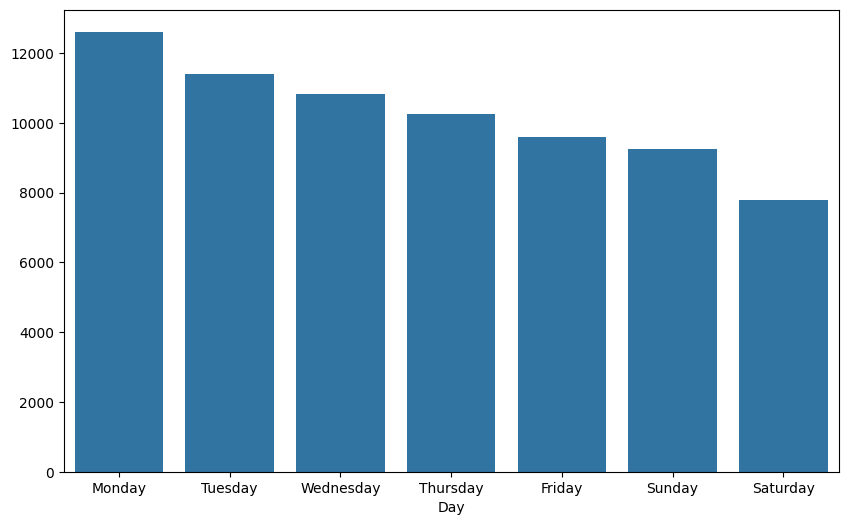

In [12]:
plt.figure(figsize = (10,6))
sns.barplot(x = df['Day'].value_counts().index, y= df['Day'].value_counts().values )
plt.show()

In [13]:
country_filtered = df[df['country'].isin(["United States", "Canada", "Germany", "India", "France", "Taiwan",'Italy', "Japan","Spain", "China", "Singapore", "South Korea", "Netherlands", 'Turkey','Brazil'])]

In [14]:
dummies_df = pd.get_dummies(country_filtered[['country', 'medium','source', 'mobile_brand_name','category','Day']], drop_first=True, dtype=int)
dummy_df = pd.concat([country_filtered,dummies_df], axis = 1)

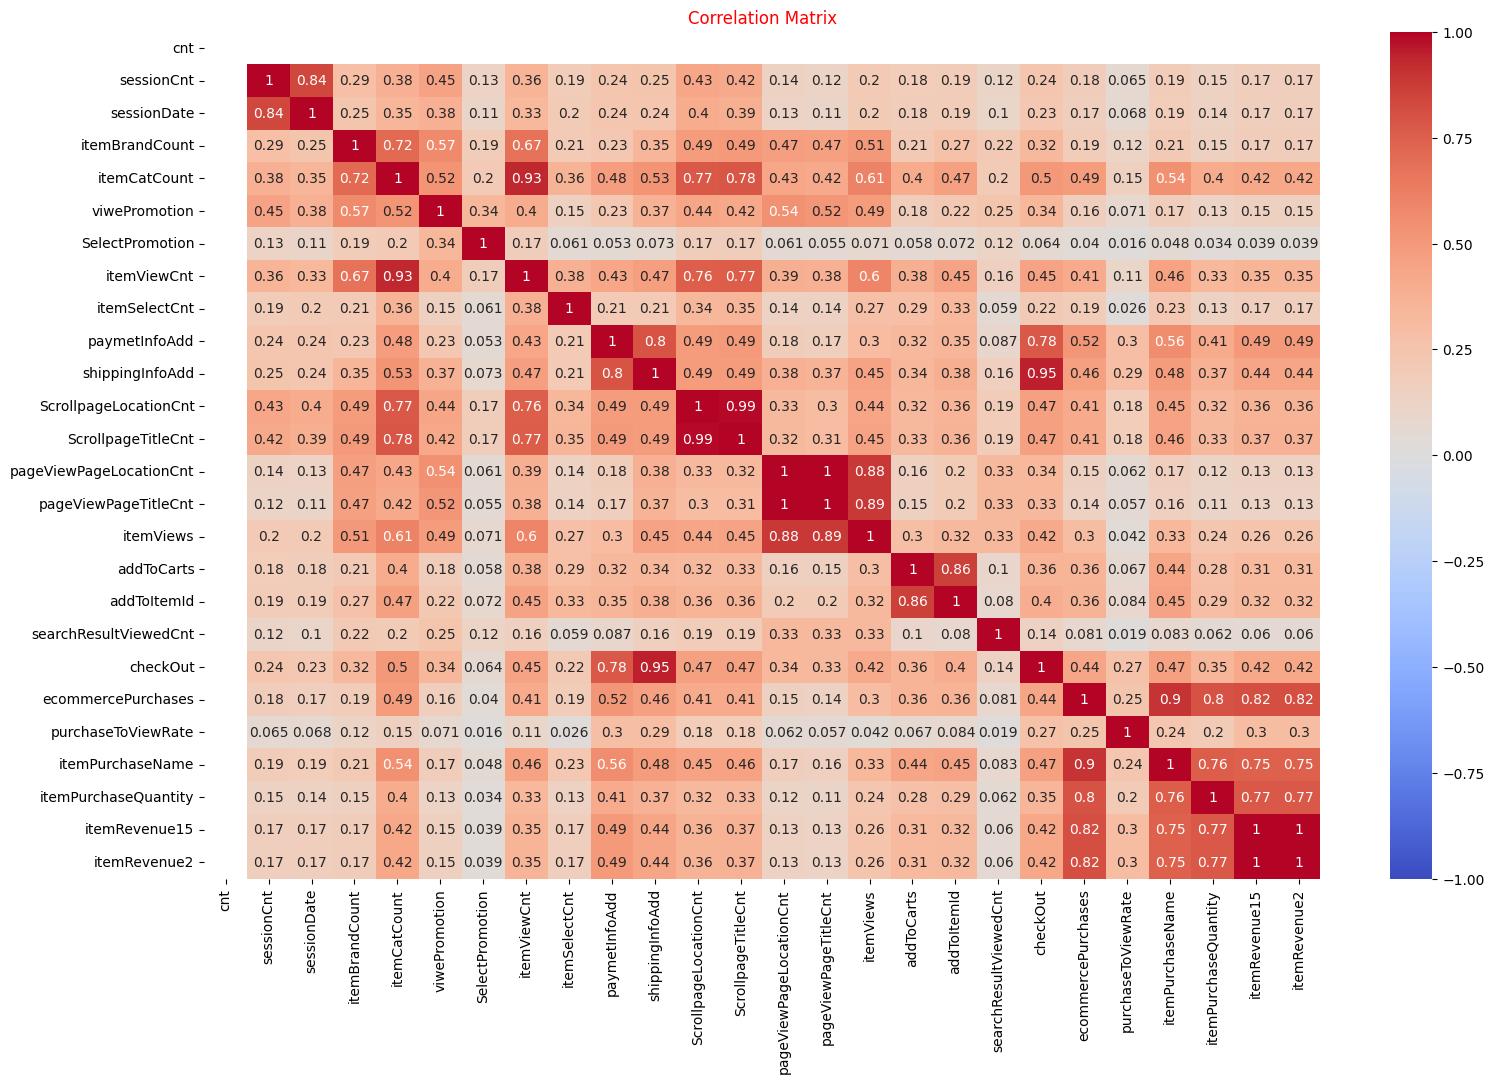

In [15]:
corr_matrix = country_filtered.select_dtypes(include=['number', 'float']).corr()
plt.figure(figsize= (18,11))
sns.heatmap(corr_matrix, annot = True, cmap= 'coolwarm', vmin= -1, vmax=1)
plt.title('Correlation Matrix', color = 'r')
plt.show( )

In [16]:
pd.set_option('display.max_columns', None)
dummy_df.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,Day,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1014376.3610855823,organic,organic,google,Apple,United States,desktop,1,2020-11-29,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,10156259.2633315386,none,direct,direct,Mozilla,United States,desktop,1,2020-11-22,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,Sunday,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,10305449.4833782585,none,direct,direct,Google,United States,desktop,1,2020-11-25,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Wednesday,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1033552.6644233006,none,direct,direct,Google,United States,desktop,1,2020-11-04,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,Wednesday,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,11267767.2804204463,organic,organic,google,Microsoft,United States,desktop,1,2020-11-11,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Wednesday,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [17]:

x = dummy_df.drop(['user_pseudo_id','name','fdate','medium','source','mobile_brand_name','country','category','Day'], axis = 1)

In [18]:
x.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


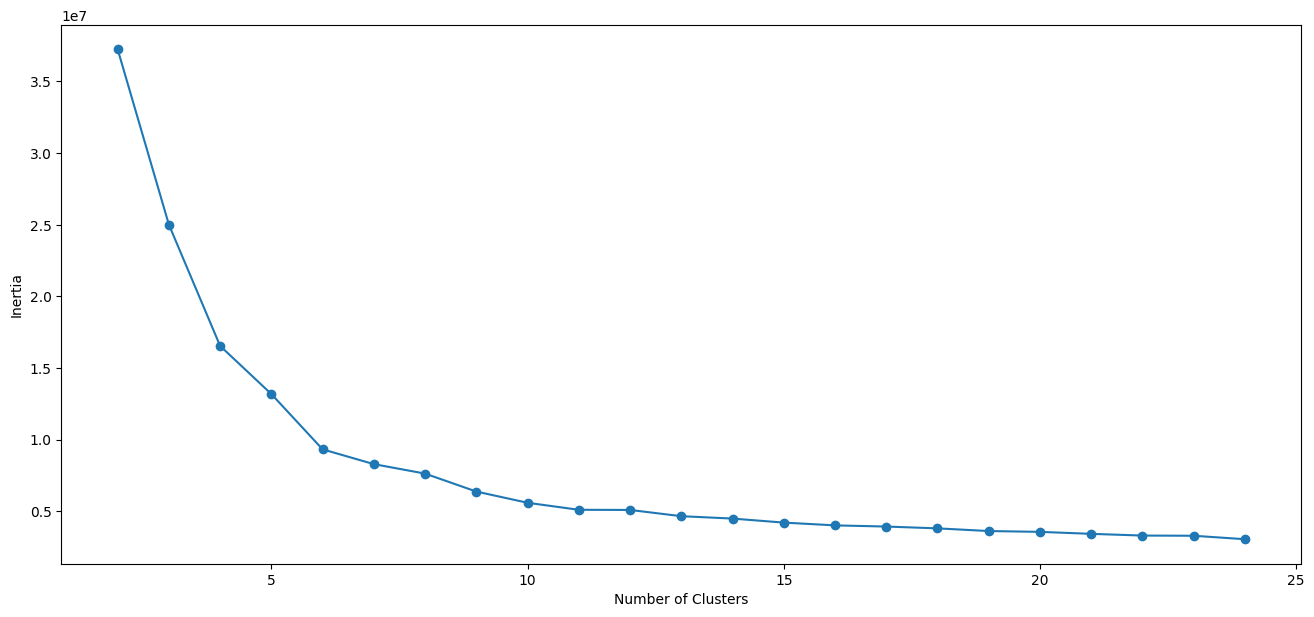

In [19]:

inertia = [] #lower is best
list_num_clusters = list(range(2,25))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, n_init='auto')
    km.fit(x)
    inertia.append(km.inertia_)

plt.figure(figsize=[16,7])
plt.plot(list_num_clusters, inertia)
plt.scatter(list_num_clusters, inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

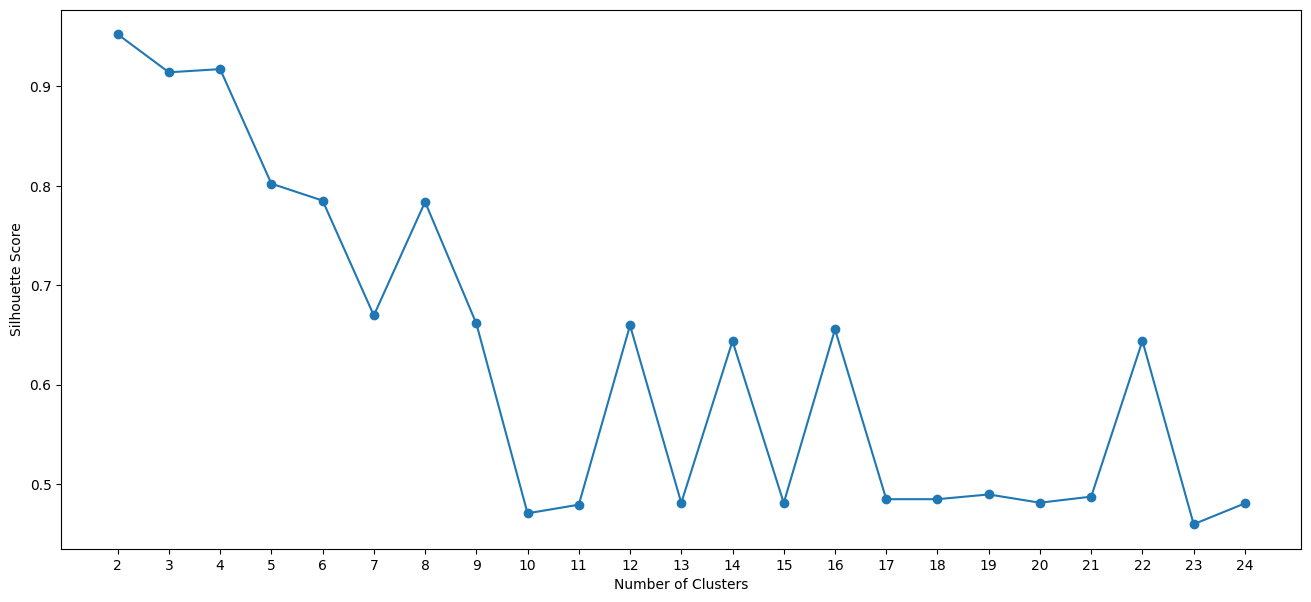

In [20]:
silhouette = []  ##higher is best
list_num_clusters = list(range(2,25))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, n_init='auto', init = 'k-means++')
    km.fit(x)
    silhouette.append(silhouette_score(x, km.labels_))

plt.figure(figsize=[16,7])  
plt.plot(list_num_clusters, silhouette)
plt.scatter(list_num_clusters, silhouette)
plt.xticks(range(2,25))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score');

In [21]:
km = KMeans(n_clusters=4, n_init='auto', init = 'k-means++')
km.fit(x)
x['ClusterNo'] = km.labels_
x.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,ClusterNo
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3


In [22]:
x.ClusterNo.value_counts()


ClusterNo
3    54991
2      609
0      424
1       35
Name: count, dtype: int64

C:\Users\w11\AppData\Local\Temp\ipykernel_14140\478532041.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_itemRevenue15_means.index, y=cluster_itemRevenue15_means.values, palette='viridis')


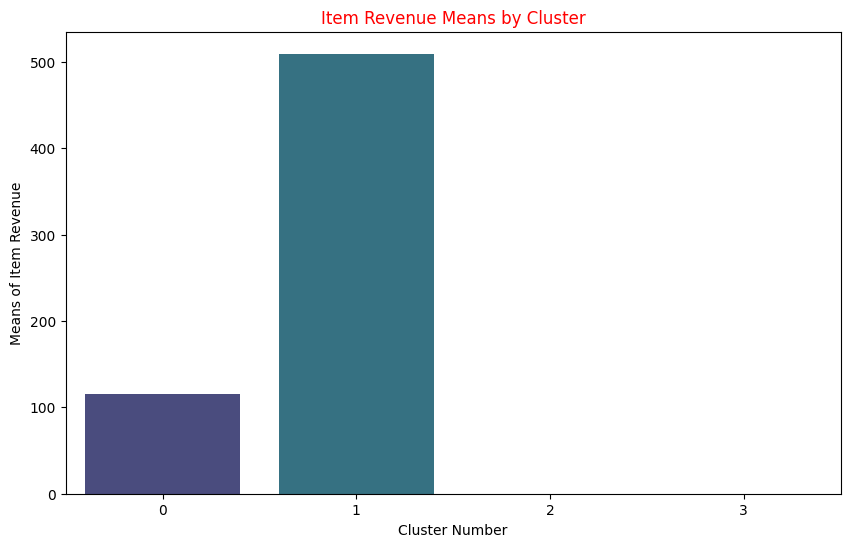

In [23]:
cluster_itemRevenue15_means = x.groupby('ClusterNo').itemRevenue15.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_itemRevenue15_means.index, y=cluster_itemRevenue15_means.values, palette='viridis')
plt.xlabel('Cluster Number')
plt.ylabel('Means of Item Revenue')
plt.title('Item Revenue Means by Cluster', color = 'r')
plt.show()

C:\Users\w11\AppData\Local\Temp\ipykernel_14140\1733361517.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_sessionDate_means.index, y=cluster_sessionDate_means.values, palette='viridis')


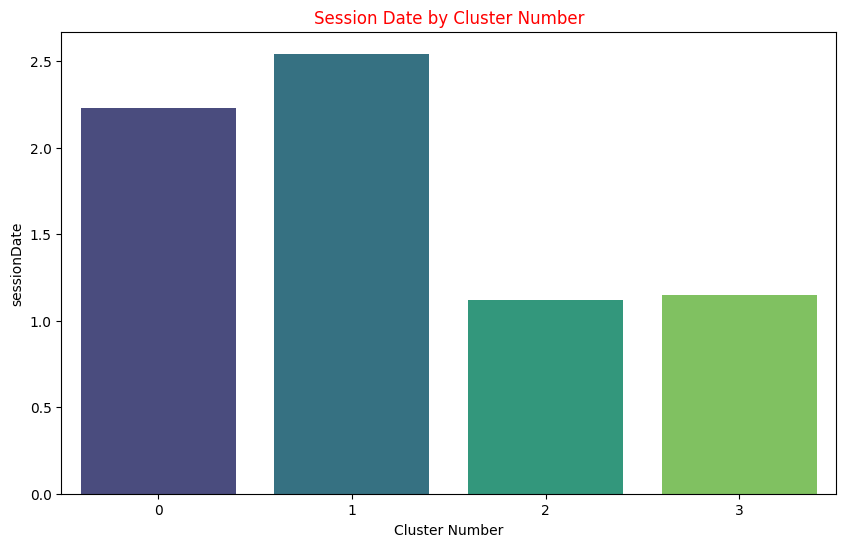

In [24]:
cluster_sessionDate_means = x.groupby('ClusterNo').sessionDate.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_sessionDate_means.index, y=cluster_sessionDate_means.values, palette='viridis')
plt.xlabel('Cluster Number')
plt.ylabel('sessionDate')
plt.title('Session Date by Cluster Number', color = 'r')
plt.show()

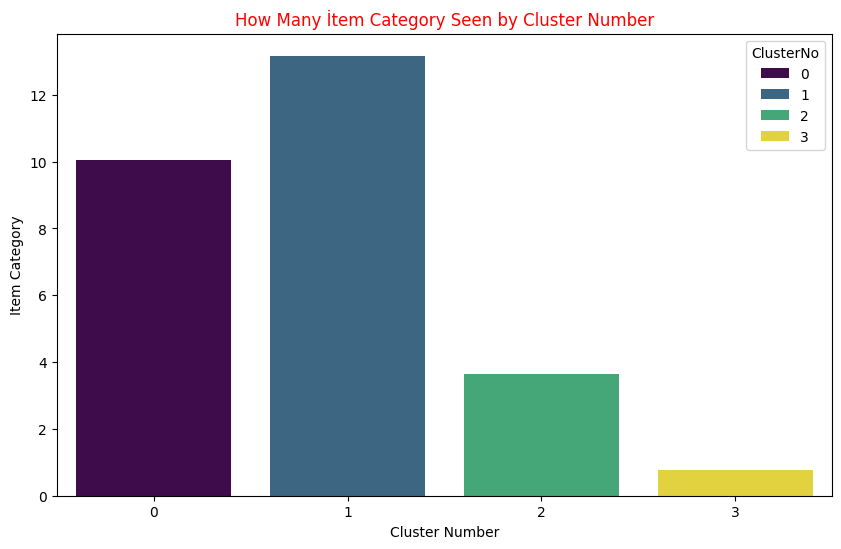

In [25]:
cluster_itemCatCount_means = x.groupby('ClusterNo').itemCatCount.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_itemCatCount_means.index, y=cluster_itemCatCount_means.values, palette='viridis', hue = cluster_itemCatCount_means.index)
plt.xlabel('Cluster Number')
plt.ylabel('Item Category')
plt.title('How Many İtem Category Seen by Cluster Number', color = 'r')
plt.show()

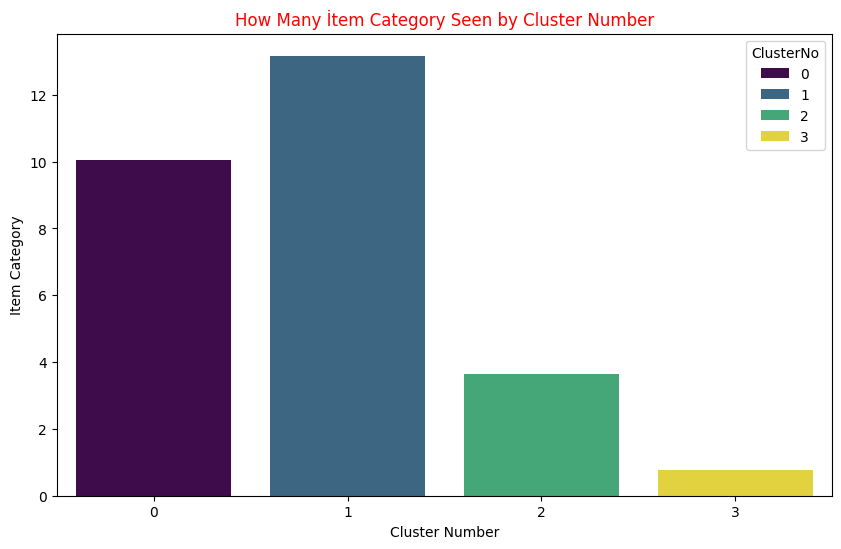

In [26]:
cluster_itemCatCount_means = x.groupby('ClusterNo').itemCatCount.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_itemCatCount_means.index, y=cluster_itemCatCount_means.values, palette='viridis', hue = cluster_itemCatCount_means.index)
plt.xlabel('Cluster Number')
plt.ylabel('Item Category')
plt.title('How Many İtem Category Seen by Cluster Number', color = 'r')
plt.show()

In [27]:
X = x.drop(['ClusterNo'], axis= 1)
Y = x['ClusterNo']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size= 0.20, random_state= 42)

In [28]:
x_train

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
12460,1,3,3,2,3,1,0,13,0,0,0,3,3,6,6,9,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
30747,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
60369,1,1,1,3,4,6,0,13,0,0,1,1,1,98,98,46,2,12,2,1,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10085,1,2,2,2,8,2,0,37,0,3,2,7,7,10,10,8,5,23,0,3,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
36193,1,2,1,2,3,0,0,23,0,0,0,4,4,6,6,3,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57324,1,1,1,1,1,3,0,0,0,0,0,5,5,7,7,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
69586,1,2,1,1,1,1,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
48925,1,1,1,0,0,1,0,0,0,0,0,1,1,2,2,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1089,1,1,1,2,1,0,0,11,0,0,0,1,1,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
X.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [30]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

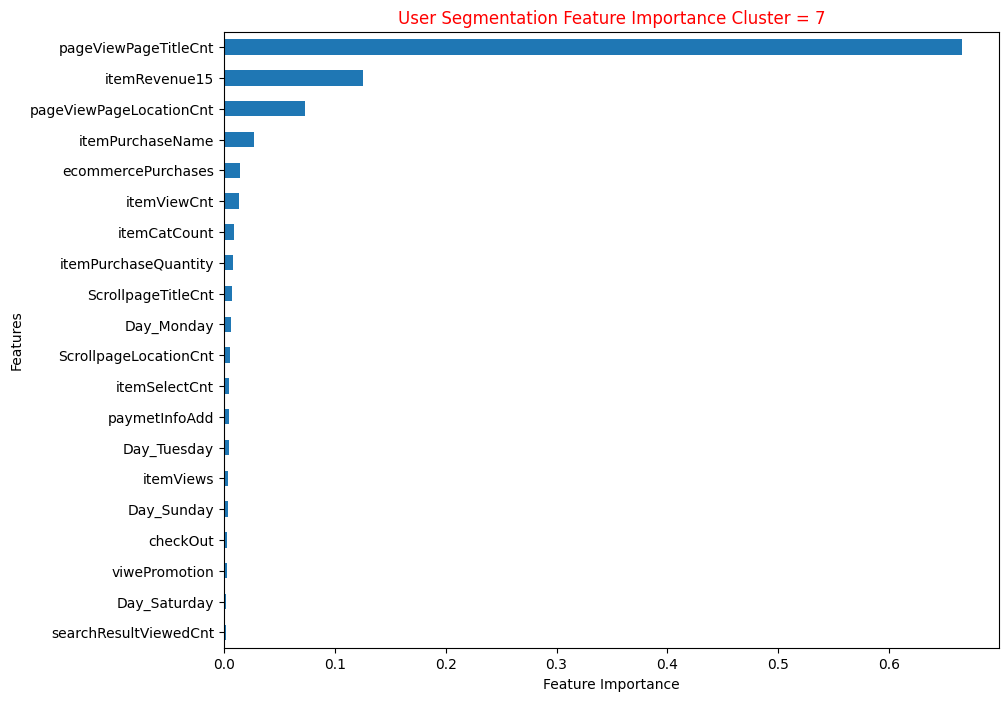

In [31]:
plt.figure(figsize= (10,8))
feature_importance = pd.Series(xgb.feature_importances_, index=x_train.columns).nlargest(20)
feature_importance.nlargest(20).plot(kind = 'barh')
plt.title('User Segmentation Feature Importance Cluster = 7', color = 'r')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.gca().invert_yaxis()
plt.show()

<Figure size 1800x800 with 0 Axes>

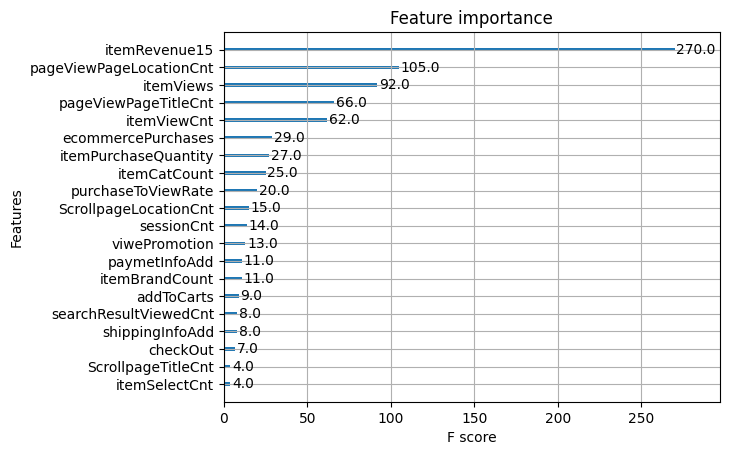

In [32]:
plt.figure(figsize= (18,8))
xgbt.plot_importance(xgb, max_num_features =20)
plt.show()

### DBSCAN

In [33]:
x_dbscan =  x.drop(['ClusterNo'], axis= 1)

In [34]:
## Calculate Silhouette Score for More Than 1 Cluster
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(x_dbscan)
    if len(set(labels)) > 1:
        return silhouette_score(x_dbscan, labels)
    else:
        return -1

In [35]:
dbscan = DBSCAN(eps= 0.5, min_samples= 100)

In [36]:
x_dbscan.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [37]:
x_dbscan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56059 entries, 0 to 71737
Data columns (total 64 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cnt                                     56059 non-null  Int64  
 1   sessionCnt                              56059 non-null  Int64  
 2   sessionDate                             56059 non-null  Int64  
 3   itemBrandCount                          56059 non-null  Int64  
 4   itemCatCount                            56059 non-null  Int64  
 5   viwePromotion                           56059 non-null  Int64  
 6   SelectPromotion                         56059 non-null  Int64  
 7   itemViewCnt                             56059 non-null  Int64  
 8   itemSelectCnt                           56059 non-null  Int64  
 9   paymetInfoAdd                           56059 non-null  Int64  
 10  shippingInfoAdd                         56059 non-null  Int64  

In [38]:
X.head()


,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [39]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56059 entries, 0 to 71737
Data columns (total 64 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cnt                                     56059 non-null  Int64  
 1   sessionCnt                              56059 non-null  Int64  
 2   sessionDate                             56059 non-null  Int64  
 3   itemBrandCount                          56059 non-null  Int64  
 4   itemCatCount                            56059 non-null  Int64  
 5   viwePromotion                           56059 non-null  Int64  
 6   SelectPromotion                         56059 non-null  Int64  
 7   itemViewCnt                             56059 non-null  Int64  
 8   itemSelectCnt                           56059 non-null  Int64  
 9   paymetInfoAdd                           56059 non-null  Int64  
 10  shippingInfoAdd                         56059 non-null  Int64  

In [40]:
x_dbscan['cluster2'] = dbscan.fit_predict(x_dbscan)

In [41]:
x_dbscan.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,cluster2
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,-1
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-1
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,-1
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,-1


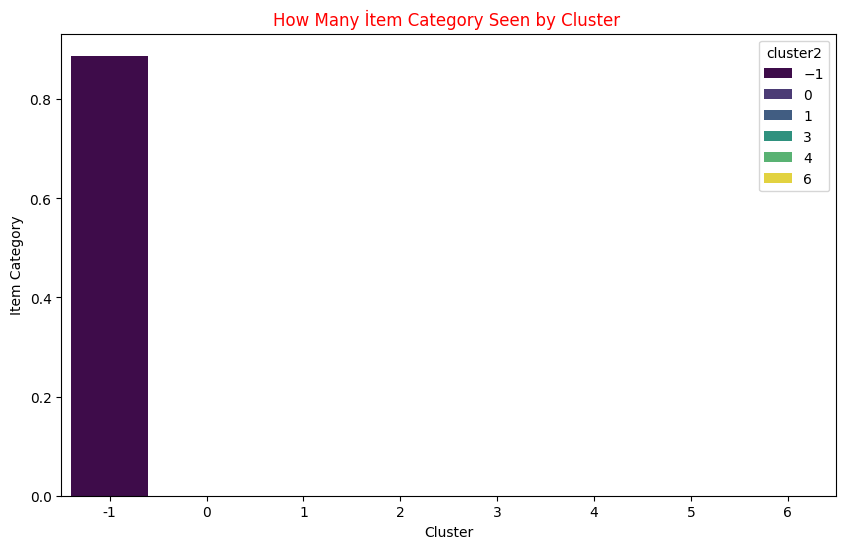

In [42]:
cluster_itemCatCount_means = x_dbscan.groupby('cluster2').itemCatCount.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_itemCatCount_means.index, y=cluster_itemCatCount_means.values, palette='viridis', hue = cluster_itemCatCount_means.index)
plt.xlabel('Cluster')
plt.ylabel('Item Category')
plt.title('How Many İtem Category Seen by Cluster ', color = 'r')
plt.show()

In [43]:
x_dbscan['cluster2'].value_counts()

cluster2
-1    55234
 1      129
 5      127
 0      126
 2      115
 4      113
 6      113
 3      102
Name: count, dtype: int64

C:\Users\w11\AppData\Local\Temp\ipykernel_14140\3033718883.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_itemRevenue15_means.index, y=cluster_itemRevenue15_means.values, palette='viridis')


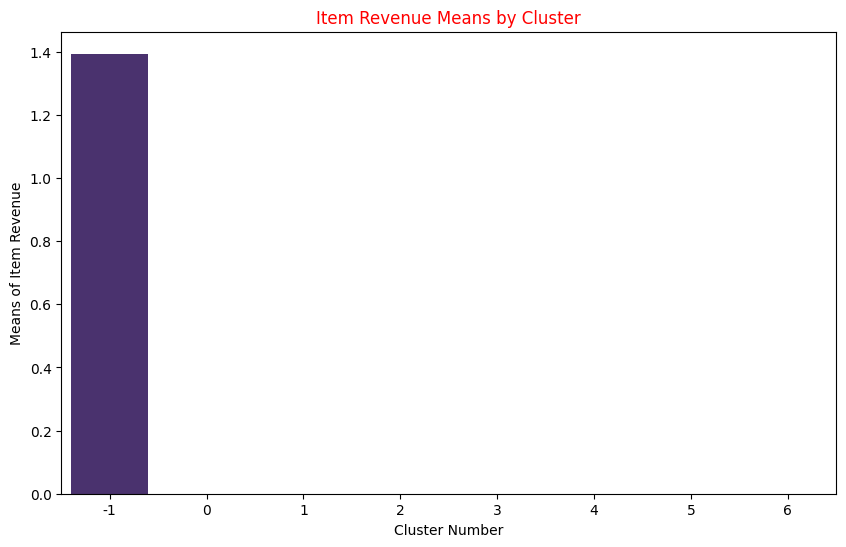

In [44]:
cluster_itemRevenue15_means = x_dbscan.groupby('cluster2').itemRevenue15.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=cluster_itemRevenue15_means.index, y=cluster_itemRevenue15_means.values, palette='viridis')
plt.xlabel('Cluster Number')
plt.ylabel('Means of Item Revenue')
plt.title('Item Revenue Means by Cluster', color = 'r')
plt.show()

In [45]:
x.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,ClusterNo
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3


## Hierarchichal Clustering

In [46]:
x_h = x.drop(['ClusterNo'], axis = 1)


In [47]:
x_h =x.copy()

In [48]:
scaler = StandardScaler()
x_hs = scaler.fit_transform(x_h)

In [49]:
##dendrogram_ward = sch.dendrogram(sch.linkage(x_hs, method='ward'), truncate_mode='level', p=100)  ## level = 4 , display first 4 level

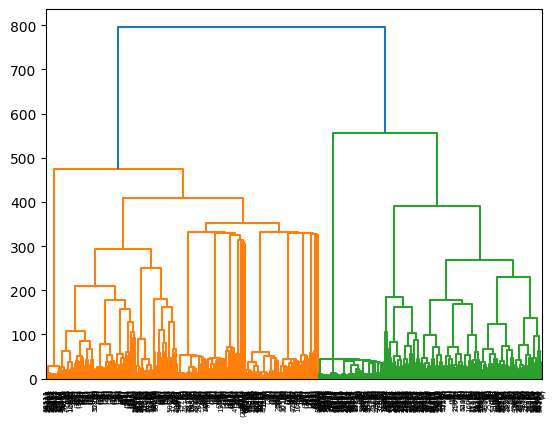

In [50]:
dendrogram_ward = sch.dendrogram(sch.linkage(x_hs, method='ward'), truncate_mode='level', p=10)  ## level = 4 , display first 4 level

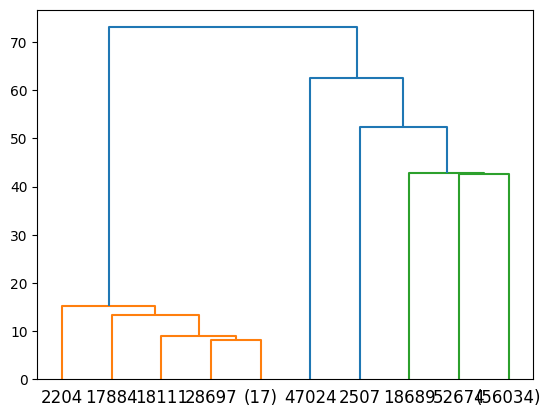

In [51]:
dendrogram_sinle = sch.dendrogram(sch.linkage(x_hs, method='single'), truncate_mode='level', p=4) ## level = 4 , display first 4 level

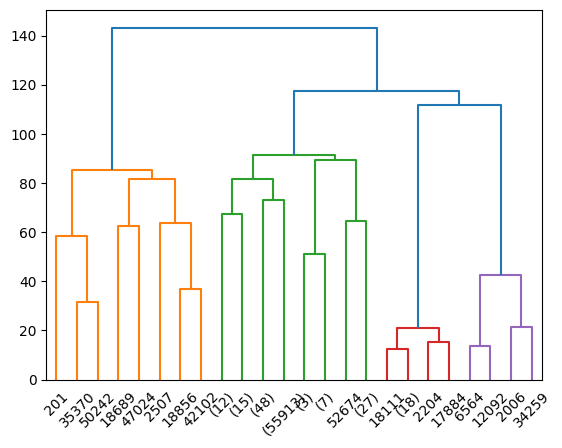

In [52]:
dendrogram_compl = sch.dendrogram(sch.linkage(x_hs, method='complete'), truncate_mode='level', p=4)  ## level = 4 , display first 4 level

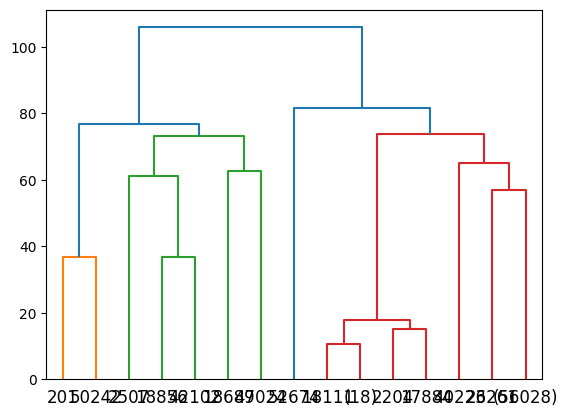

In [53]:
dendrogram_avg = sch.dendrogram(sch.linkage(x_hs, method='average'), truncate_mode='level', p=4) 

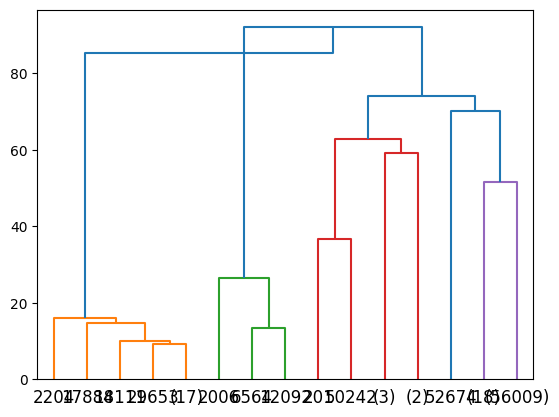

In [54]:
dendrogram_avg = sch.dendrogram(sch.linkage(x_hs, method='median'), truncate_mode='level', p=4)  ## level = 4 , display first 4 level

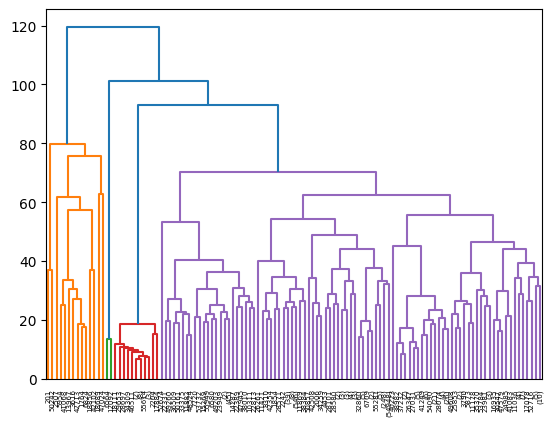

In [55]:
dendrogram_avg = sch.dendrogram(sch.linkage(x_hs, method='weighted'), truncate_mode='level', p=10)  ## level = 4 , display first 4 level

#### Model Training Hierarchical Clustring

In [56]:
hc_model_ward = AgglomerativeClustering(n_clusters=3, metric='euclidean',  linkage='ward')
clusters_ward = hc_model_ward.fit_predict(x_hs)
sil_score_ward = silhouette_score(x_hs, clusters_ward)
print(clusters_ward)
print(sil_score_ward)

[0 0 0 ... 0 0 0]
0.5113029403013318


In [57]:
hc_model_single = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='single')
clusters_single = hc_model_single.fit_predict(x_hs)
sil_score_single = silhouette_score(x_hs, clusters_single)
print(clusters_single)
print(sil_score_single)

[0 0 0 ... 0 0 0]
0.866913424330059


In [58]:
hc_model_complete = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete')
clusters_complete = hc_model_complete.fit_predict(x_hs)
sil_score_complete = silhouette_score(x_hs, clusters_complete)
print(clusters_complete)
print(sil_score_complete)

[2 2 2 ... 2 2 2]
0.8642752984956397


In [59]:

# Calinski-Harabasz Score  higher is the best
ch_score_ward = calinski_harabasz_score(x_hs, clusters_ward)
ch_score_single = calinski_harabasz_score(x_hs, clusters_single)
ch_score_complete = calinski_harabasz_score(x_hs, clusters_complete)

print(f'Calinski-Harabasz Score (Ward): {ch_score_ward}')
print(f'Calinski-Harabasz Score (Single): {ch_score_single}')
print(f'Calinski-Harabasz Score (Complete): {ch_score_complete}')


Calinski-Harabasz Score (Ward): 4252.234267455969
Calinski-Harabasz Score (Single): 1022.9871883835356
Calinski-Harabasz Score (Complete): 1343.6963583892004


In [60]:

# Davies-Bouldin Score lower is the best
db_score_ward = davies_bouldin_score(x_hs, clusters_ward)
db_score_single = davies_bouldin_score(x_hs, clusters_single)
db_score_complete = davies_bouldin_score(x_hs, clusters_complete)

print(f'Davies-Bouldin Score (Ward): {db_score_ward}')
print(f'Davies-Bouldin Score (Single): {db_score_single}')
print(f'Davies-Bouldin Score (Complete): {db_score_complete}')


Davies-Bouldin Score (Ward): 1.2470069362985283
Davies-Bouldin Score (Single): 0.13937750986297112
Davies-Bouldin Score (Complete): 0.625787039750477


###### Ward Yöntemi: Calinski-Harabasz skoruna göre en iyi kümeleme performansını sağlıyor. Bu yöntem, kümeler arasındaki ayrımı ve kümelerin içindeki kompaktlığı en iyi şekilde sağlıyor.
###### Single Yöntemi: Davies-Bouldin skoruna göre en iyi performansı gösteriyor. Bu yöntem, kümeler arasındaki benzerliği minimize ediyor ve kümeleri iyi bir şekilde ayrıştırıyor.
###### Complete Yöntemi:Her iki metriğe göre de ortalama bir performans gösteriyor.
##### Hangi Yöntemi Seçmelisiniz?
Eğer kümelerin ayrımını ve içindeki kompaktlığı öncelikliyorsanız, Ward yöntemi en iyi seçenek olabilir.
Eğer kümelerin birbirine olan benzerliğini minimize etmek istiyorsanız, Single yöntemi en iyi seçenektir.
Complete yöntemi, genel anlamda ortalama bir performans sunar ve hem ayrımı hem de benzerliği dengeli bir şekilde optimize eder.
Bu durumda, analiz amacınıza bağlı olarak Ward veya Single yöntemini seçmek mantıklı olacaktır. Eğer her iki metriği de dikkate almak istiyorsanız, Complete yöntemi de tercih edilebilir.

In [61]:
x_hs = pd.DataFrame(x_hs)

In [62]:
x_hs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0.0,-0.375785,-0.301282,-0.740616,-0.491234,-0.576745,-0.16498,-0.373428,-0.10154,-0.107537,-0.167344,-0.165125,-0.153311,-0.266504,-0.255628,-0.238603,-0.094273,-0.126623,-0.154613,-0.152599,-0.08054,-0.067866,-0.090497,-0.065677,-0.077638,-0.077638,-0.322763,-0.148904,-0.161501,-0.155709,-0.369116,-0.137554,-0.132834,-0.12055,-0.128885,-0.124894,-0.158511,-0.145233,-0.113984,0.881699,-0.23962,-0.019358,-0.559034,1.263585,-0.405376,-0.019358,-0.559034,1.207198,-0.227386,-0.733953,-0.125188,-0.159924,-0.120398,-0.286376,-0.279722,-0.154018,-0.812751,-0.151203,-0.461808,-0.349621,2.596926,-0.406241,-0.434336,-0.421615,0.122876
1,0.0,-0.375785,-0.301282,-0.740616,-0.491234,-0.576745,-0.16498,-0.373428,-0.10154,-0.107537,-0.167344,-0.562204,-0.570114,-0.266504,-0.255628,-0.101443,-0.094273,-0.126623,-0.154613,-0.152599,-0.08054,-0.067866,-0.090497,-0.065677,-0.077638,-0.077638,-0.322763,-0.148904,-0.161501,-0.155709,-0.369116,-0.137554,-0.132834,-0.12055,-0.128885,-0.124894,-0.158511,-0.145233,-0.113984,0.881699,-0.23962,-0.019358,1.788800,-0.791399,-0.405376,-0.019358,1.788800,-0.828365,-0.227386,-0.733953,-0.125188,-0.159924,8.305797,-0.286376,-0.279722,-0.154018,-0.812751,-0.151203,-0.461808,-0.349621,2.596926,-0.406241,-0.434336,-0.421615,0.122876
2,0.0,-0.375785,-0.301282,-0.740616,-0.491234,-0.576745,-0.16498,-0.373428,-0.10154,-0.107537,-0.167344,-0.562204,-0.570114,-0.266504,-0.255628,-0.238603,-0.094273,-0.126623,-0.154613,-0.152599,-0.08054,-0.067866,-0.090497,-0.065677,-0.077638,-0.077638,-0.322763,-0.148904,-0.161501,-0.155709,-0.369116,-0.137554,-0.132834,-0.12055,-0.128885,-0.124894,-0.158511,-0.145233,-0.113984,0.881699,-0.23962,-0.019358,1.788800,-0.791399,-0.405376,-0.019358,1.788800,-0.828365,-0.227386,1.362484,-0.125188,-0.159924,-0.120398,-0.286376,-0.279722,-0.154018,-0.812751,-0.151203,-0.461808,-0.349621,-0.385071,-0.406241,-0.434336,2.371830,0.122876
3,0.0,4.216037,3.542930,1.605839,3.439651,3.034286,-0.16498,3.169677,-0.10154,-0.107537,-0.167344,1.026114,1.097096,1.180652,0.816997,0.721516,-0.094273,-0.126623,6.830763,-0.152599,-0.08054,-0.067866,-0.090497,-0.065677,-0.077638,-0.077638,-0.322763,-0.148904,-0.161501,-0.155709,-0.369116,-0.137554,-0.132834,-0.12055,-0.128885,-0.124894,-0.158511,-0.145233,-0.113984,0.881699,-0.23962,-0.019358,1.788800,-0.791399,-0.405376,-0.019358,1.788800,-0.828365,-0.227386,1.362484,-0.125188,-0.159924,-0.120398,-0.286376,-0.279722,-0.154018,-0.812751,-0.151203,-0.461808,-0.349621,-0.385071,-0.406241,-0.434336,2.371830,0.122876
4,0.0,-0.375785,-0.301282,0.432612,0.070321,0.145462,-0.16498,-0.373428,-0.10154,-0.107537,-0.167344,-0.562204,-0.570114,-0.266504,-0.255628,-0.238603,-0.094273,-0.126623,-0.154613,-0.152599,-0.08054,-0.067866,-0.090497,-0.065677,-0.077638,-0.077638,-0.322763,-0.148904,-0.161501,-0.155709,-0.369116,-0.137554,-0.132834,-0.12055,-0.128885,-0.124894,-0.158511,-0.145233,-0.113984,0.881699,-0.23962,-0.019358,-0.559034,1.263585,-0.405376,-0.019358,-0.559034,1.207198,-0.227386,-0.733953,-0.125188,6.252954,-0.120398,-0.286376,-0.279722,-0.154018,-0.812751,-0.151203,-0.461808,-0.349621,-0.385071,-0.406241,-0.434336,2.371830,0.122876


In [63]:
x_h.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,ClusterNo
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3


In [64]:
x.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,ClusterNo
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3


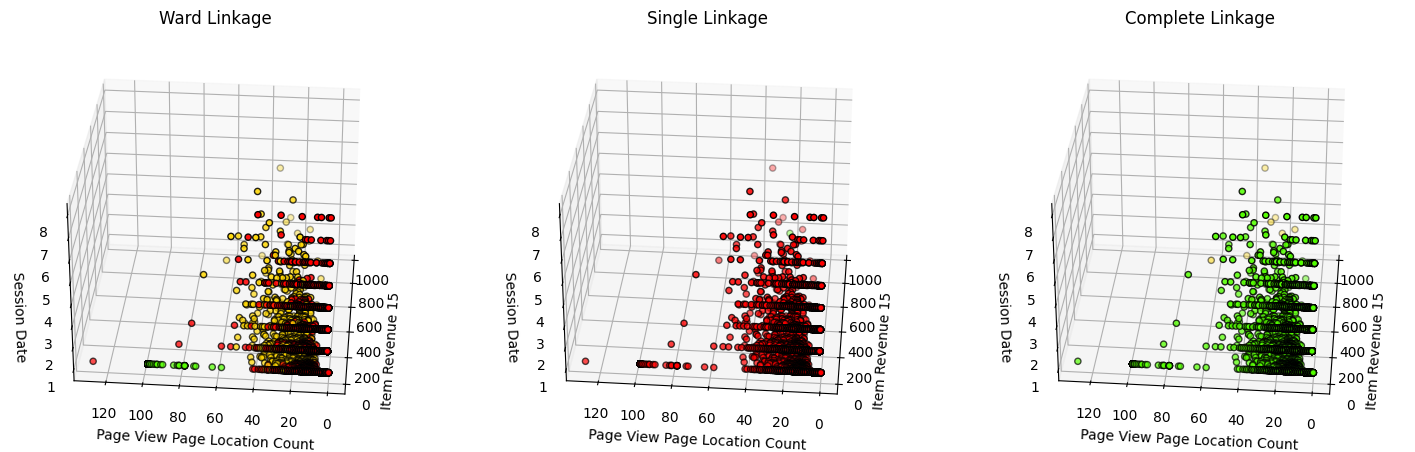

In [65]:
fig = plt.figure(figsize=(18, 10))

# 1. Ward Linkage Plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x_h['itemRevenue15'], x_h['pageViewPageLocationCnt'], x_h['sessionDate'], c=clusters_ward, cmap='prism', edgecolor='k')
ax1.set_title('Ward Linkage')

# 2. Single Linkage Plot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x_h['itemRevenue15'], x_h['pageViewPageLocationCnt'], x_h['sessionDate'], c=clusters_single, cmap='prism', edgecolor='k')
ax2.set_title('Single Linkage')

# 3. Complete Linkage Plot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x_h['itemRevenue15'], x_h['pageViewPageLocationCnt'], x_h['sessionDate'], c=clusters_complete, cmap='prism', edgecolor='k')
ax3.set_title('Complete Linkage')

# Visual Seted
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Item Revenue 15')
    ax.set_ylabel('Page View Page Location Count')
    ax.set_zlabel('Session Date')
    ax.view_init(30, 185)

plt.show()

#### Cluster ward Visusalization

In [66]:
x_h['clusters_ward'] = clusters_ward
x_h.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,ClusterNo,clusters_ward
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,3,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,3,0


In [67]:
X['clusters_ward'] = clusters_ward
X.head()

,cnt,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,country_Canada,country_China,country_France,country_Germany,country_India,country_Italy,country_Japan,country_Netherlands,country_Singapore,country_South Korea,country_Spain,country_Taiwan,country_Turkey,country_United States,medium_cpc,medium_data deleted,medium_none,medium_organic,medium_referral,source_data deleted,source_direct,source_google,source_shop.googlemerchandisestore.com,mobile_brand_name_Google,mobile_brand_name_Huawei,mobile_brand_name_Microsoft,mobile_brand_name_Mozilla,mobile_brand_name_Other,mobile_brand_name_Samsung,mobile_brand_name_Xiaomi,category_mobile,category_tablet,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,clusters_ward
0,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,1,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [68]:
 X.to_pickle('xh_cluster_ward2')

In [69]:
X.to_parquet("xh_cluster_ward2.parquet")

In [70]:
 x_h.to_pickle('xh_cluster_ward')

In [73]:
X.to_parquet("xh_cluster_ward.parquet")

In [74]:
x_h.clusters_ward.value_counts()

clusters_ward
0    54830
1      651
2      578
Name: count, dtype: int64

In [75]:
country_filtered.head()

,user_pseudo_id,medium,name,source,mobile_brand_name,country,category,cnt,fdate,sessionCnt,sessionDate,itemBrandCount,itemCatCount,viwePromotion,SelectPromotion,itemViewCnt,itemSelectCnt,paymetInfoAdd,shippingInfoAdd,ScrollpageLocationCnt,ScrollpageTitleCnt,pageViewPageLocationCnt,pageViewPageTitleCnt,itemViews,addToCarts,addToItemId,searchResultViewedCnt,checkOut,ecommercePurchases,purchaseToViewRate,itemPurchaseName,itemPurchaseQuantity,itemRevenue15,itemRevenue2,Day
0,1014376.3610855823,organic,organic,google,Apple,United States,desktop,1,2020-11-29,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Sunday
1,10156259.2633315386,none,direct,direct,Mozilla,United States,desktop,1,2020-11-22,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0.0,0,0,0.0,0.0,Sunday
2,10305449.4833782585,none,direct,direct,Google,United States,desktop,1,2020-11-25,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Wednesday
3,1033552.6644233006,none,direct,direct,Google,United States,desktop,1,2020-11-04,5,3,2,7,5,0,37,0,0,0,4,4,16,12,7,0,0,5,0,0,0.0,0,0,0.0,0.0,Wednesday
8,11267767.2804204463,organic,organic,google,Microsoft,United States,desktop,1,2020-11-11,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0,0,0.0,0.0,Wednesday


In [76]:
country_filtered['clusters_ward'] = clusters_ward
country_filtered.to_pickle('country_filtered_cluster_ward')
country_filtered.to_parquet("country_filtered_cluster_ward.parquet")

C:\Users\w11\AppData\Local\Temp\ipykernel_14140\1413646714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_filtered['clusters_ward'] = clusters_ward


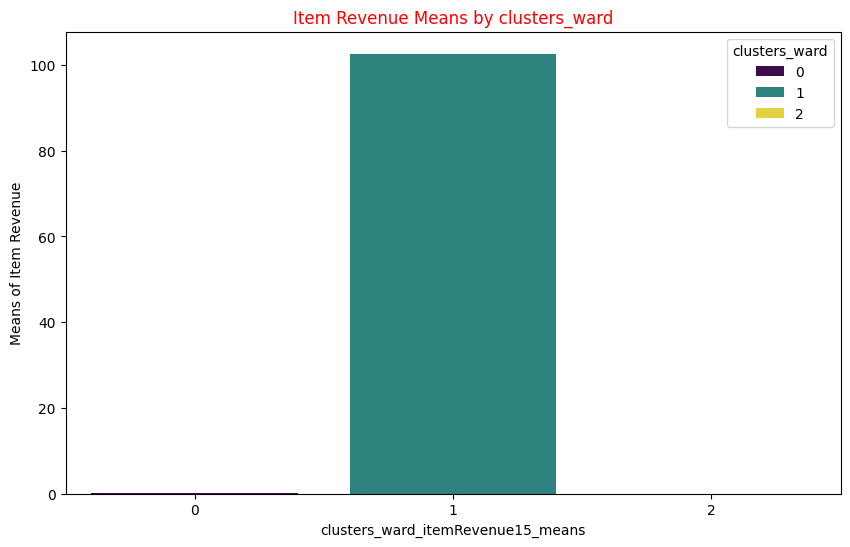

In [77]:
clusters_ward_itemRevenue15_means = x_h.groupby('clusters_ward').itemRevenue15.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=clusters_ward_itemRevenue15_means.index, y=clusters_ward_itemRevenue15_means.values, palette='viridis', hue = clusters_ward_itemRevenue15_means.index)
plt.xlabel('clusters_ward_itemRevenue15_means')
plt.ylabel('Means of Item Revenue')
plt.title('Item Revenue Means by clusters_ward', color = 'r')
plt.show()

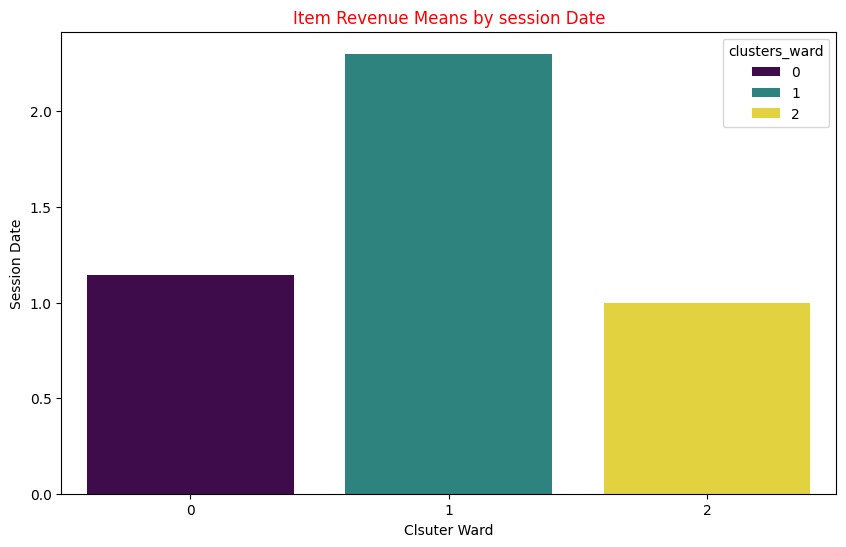

In [78]:
clusters_ward_sessionDate_means = x_h.groupby('clusters_ward').sessionDate.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=clusters_ward_sessionDate_means.index, y=clusters_ward_sessionDate_means.values, palette='viridis', hue = clusters_ward_sessionDate_means.index)
plt.xlabel('Clsuter Ward')
plt.ylabel('Session Date')
plt.title('Item Revenue Means by session Date', color = 'r')
plt.show()

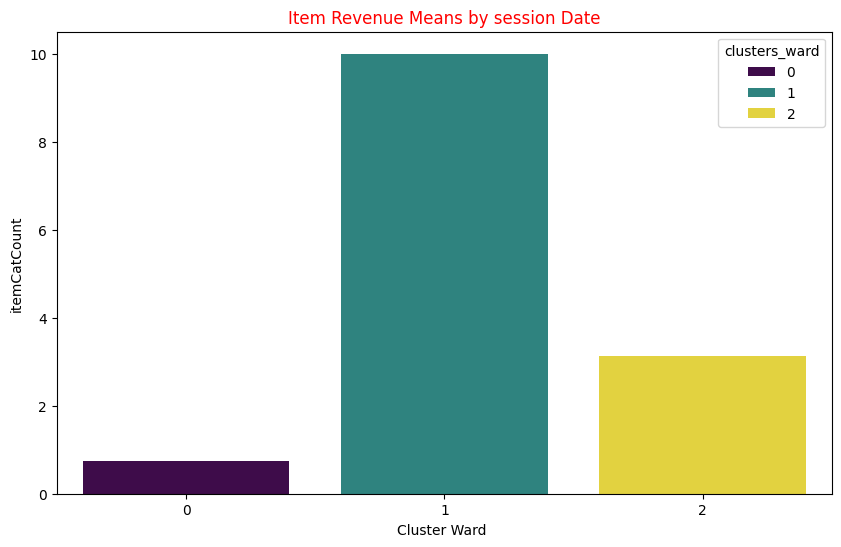

In [79]:
clusters_ward_itemCatCount_means = x_h.groupby('clusters_ward').itemCatCount.mean()
plt.figure(figsize=(10, 6))
sns.barplot(x=clusters_ward_itemCatCount_means.index, y=clusters_ward_itemCatCount_means.values, palette='viridis', hue = clusters_ward_itemCatCount_means.index)
plt.xlabel('Cluster Ward ')
plt.ylabel('itemCatCount')
plt.title('Item Revenue Means by session Date', color = 'r')
plt.show()

In [80]:
import plotly.express as px
import pandas as pd

def plot_cluster_means(dataframe, cluster_column, value_column):
    # Grup ortalamalarını hesapla
    cluster_means = dataframe.groupby(cluster_column)[value_column].mean().reset_index()
    plt.figure(figsize=(10, 6))
    # Plotly ile bar chart çizimi
    fig = px.bar(
        cluster_means, 
        x=cluster_column, 
        y=value_column, 
        color=cluster_column, 
        title=f"{value_column} Means by {cluster_column}",
        labels={cluster_column: "Cluster", value_column: "Mean Value"}
    )

    fig.show()

# Fonksiyonu kullanarak grafiği oluşturabilirsiniz
plot_cluster_means(x_h, 'clusters_ward', 'sessionDate')


<Figure size 1000x600 with 0 Axes>

In [81]:
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import pandas as pd
import plotly.express as px
import dash_bootstrap_components as dbc


external_stylesheets = [dbc.themes.CERULEAN]
app = Dash(__name__, external_stylesheets=external_stylesheets)


app.layout = dbc.Container([
    dbc.Row([
        html.Div('Cluster Ward Visualization with Data, Graph, and Controls', className="text-primary text-center fs-3")
    ]),

    dbc.Row([
        dbc.RadioItems(options=[{"label": x, "value": x} for x in x_h.columns if x != 'clusters_ward'],
                       value='sessionDate',
                       inline=True,
                       id='radio-buttons-final')
    ]),

    dbc.Row([
        dbc.Col([
            dash_table.DataTable(data=x_h.to_dict('records'), page_size=12, style_table={'overflowX': 'auto'})
        ], width=4),  

        dbc.Col([
            dcc.Graph(figure={}, id='my-first-graph-final')
        ], width=8), 
    ]),

], fluid=True)


@callback(
    Output(component_id='my-first-graph-final', component_property='figure'),
    Input(component_id='radio-buttons-final', component_property='value')
)
def update_graph(col_chosen):
    fig = px.histogram(x_h, 
                       x='clusters_ward', 
                       y=col_chosen, 
                       histfunc='avg',
                       category_orders={'clusters_ward': [0, 1, 2]},
                       color='clusters_ward',  
                       color_discrete_sequence=px.colors.qualitative.Bold)  
    return fig


if __name__ == '__main__':
    app.run(debug=True)


In [82]:
import plotly.express as px
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Dropdown menülerini oluştur
cluster_dropdown = widgets.Dropdown(
    options=x_h.columns,
    value='clusters_ward',
    description='Cluster Column:',
)

value_dropdown = widgets.Dropdown(
    options=x_h.columns,
    value='sessionDate',
    description='Value Column:',
)

def update_graph(cluster_column, value_column):
    cluster_means = x_h.groupby(cluster_column)[value_column].mean().reset_index()
    fig = px.bar(
        cluster_means, 
        x=cluster_column, 
        y=value_column, 
        color=cluster_column, 
        title=f"{value_column} Means by {cluster_column}",
        labels={cluster_column: "Cluster", value_column: "Mean Value"}
    )
    fig.show()

# Interaktif widgetları bağla
widgets.interactive(update_graph, cluster_column=cluster_dropdown, value_column=value_dropdown)

# Show Widgets
display(cluster_dropdown, value_dropdown)


Dropdown(description='Cluster Column:', index=65, options=('cnt', 'sessionCnt', 'sessionDate', 'itemBrandCount…

Dropdown(description='Value Column:', index=2, options=('cnt', 'sessionCnt', 'sessionDate', 'itemBrandCount', …

In [83]:
pip install openai
pip install langchain
pip install langchain_experimental
pip install langchain_openai

SyntaxError: invalid syntax (2289599666.py, line 1)